In [1]:
import tensorflow as tf

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
df = pd.read_excel('Cho_data.xlsx')

In [5]:
df = df.replace('nan', np.nan)

In [6]:
df.values[49:63]

array([['코스피 100', 'IDX', 'I31000010F', ..., 2064.29, 2094.68, 2072.18],
       ['코스피 100', 'IDX', 'I31000020F', ..., 2081.22, 2105.24, 2082.14],
       ['코스피 100', 'IDX', 'I31000030F', ..., 2057.06, 2071.01, 2062.27],
       ...,
       ['코스피 100', 'IDX', 'I310020822', ..., 1370993000000,
        1336340000000, 1193669000000],
       ['코스피 100', 'IDX', 'I310021112', ..., 1204998000000,
        1467448000000, 1174553000000],
       ['코스피 100', 'IDX', 'I310021122', ..., 1295408000000,
        1117254000000, 1143258000000]], dtype=object)

시가 지수만 가져와보기 

In [7]:
data_1 = (df.values[49:63,5:])

In [8]:
data_1 = data_1.astype(np.float)

In [9]:
#np.place(data_1, data_1==float(nan), np.nan)

In [10]:
data_1 = np.nan_to_num(data_1)

In [11]:
data_1

array([[0.000000e+00, 9.448500e+02, 9.490500e+02, ..., 2.064290e+03,
        2.094680e+03, 2.072180e+03],
       [0.000000e+00, 9.662200e+02, 9.503500e+02, ..., 2.081220e+03,
        2.105240e+03, 2.082140e+03],
       [0.000000e+00, 9.195900e+02, 8.934400e+02, ..., 2.057060e+03,
        2.071010e+03, 2.062270e+03],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.370993e+12,
        1.336340e+12, 1.193669e+12],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.204998e+12,
        1.467448e+12, 1.174553e+12],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.295408e+12,
        1.117254e+12, 1.143258e+12]])

In [12]:
import matplotlib.pyplot as plt

In [13]:
import matplotlib

In [14]:
%matplotlib inline

In [15]:
fig = plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

In [16]:
x = np.arange(1,len(data_1[0])+1)

In [17]:
for i in range(len(data_1)):
    plt.plot(x, normalized_data[i])

NameError: name 'normalized_data' is not defined

## 간단한 dynamic_rnn() 해보기

### 데이터 처리하는 방법 순서
- 상흠이가 준 데이터에서 시가, 고가, 저가, 종가, 수익률 등등 총 14개를 그냥 다 n_inputs 처리하기
- 각 데이터들 스케일이 다르기 때문에 normalization해줘야 함
- 각 데이터들이 총길이가 4656이기 때문에 200개의 연속된 데이터를 갖도록 랜덤하게 샘플링 해줌, 이게 n_samples 개수가 됨
- 얻어진 데이트들의 크기는 다음과 같아야 함. [n_samples, n_steps, n_inputs]

In [18]:
norm = np.linalg.norm(data_1, axis=1)

In [19]:
normalized_data = np.array([data_1[i] / norm[i] for i in range(len(data_1))])

In [20]:
np.linalg.norm(normalized_data,axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [21]:
n_samples = 2000
n_steps = 300
n_inputs = 14
n_neurons = 200
n_outputs = 14
length_data = len(data_1[0])

In [22]:
#random_idx = np.sort(np.random.choice(length_data-n_steps-1, n_samples, replace=False))
## I think we don't need to sort for randomly shuffled train and test sets.
random_idx = np.random.choice(length_data-n_steps-1, n_samples, replace=False)

In [23]:
X_data = []
Y_data = []
for i in range(n_samples):
    temp_x = []
    temp_y = []
    for j in range(n_inputs):
        temp_x.append(normalized_data[j][random_idx[i]:random_idx[i]+n_steps])
        temp_y.append(normalized_data[j][random_idx[i]+1:random_idx[i]+n_steps+1])
    X_data.append(np.array(temp_x).T)
    Y_data.append(np.array(temp_y).T)
X_data = np.array(X_data)
Y_data = np.array(Y_data)

In [24]:
train_ratio = 0.8
size_train_set = int(n_samples*0.8) 
X_data_train = np.split(X_data, [size_train_set])[0]
Y_data_train = np.split(Y_data, [size_train_set])[0]
X_data_test = np.split(X_data, [size_train_set])[1]
Y_data_test = np.split(Y_data, [size_train_set])[1]

In [25]:
len(X_data_test)

400

### outputprojectionwrapper 이용해서 만들어보기

In [69]:
tf.reset_default_graph()

In [70]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
Y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [71]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [72]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [73]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - Y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [74]:
saver = tf.train.Saver()

In [75]:
def shuffle_batch(X, Y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], Y[batch_idx]
        yield X_batch, y_batch

In [76]:
n_iterations = 1500
batch_size = 100

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        for X_batch, y_batch in shuffle_batch(X_data_train, Y_data_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, Y: y_batch})
        if iteration % 100 == 0:
            mse_train = loss.eval(feed_dict={X: X_data_train, Y: Y_data_train})
            mse_test = loss.eval(feed_dict={X: X_data_test, Y: Y_data_test})
            print(iteration, "\tMSE_train:", mse_train, "\tMSE_test:", mse_test)
            saver.save(sess, "./my_singleRNN_model") 

0 	MSE_train: 3.5822897e-05 	MSE_test: 3.487416e-05
100 	MSE_train: 1.1462624e-05 	MSE_test: 1.1469232e-05
200 	MSE_train: 7.712047e-06 	MSE_test: 7.884752e-06
300 	MSE_train: 6.236849e-06 	MSE_test: 6.4673536e-06
400 	MSE_train: 5.270791e-06 	MSE_test: 5.5284354e-06
500 	MSE_train: 4.696587e-06 	MSE_test: 4.963707e-06
600 	MSE_train: 4.10524e-06 	MSE_test: 4.388765e-06
700 	MSE_train: 3.730848e-06 	MSE_test: 4.015902e-06
800 	MSE_train: 3.4006846e-06 	MSE_test: 3.6886931e-06
900 	MSE_train: 3.3179504e-06 	MSE_test: 3.6003985e-06
1000 	MSE_train: 3.0311357e-06 	MSE_test: 3.3237854e-06
1100 	MSE_train: 2.9771e-06 	MSE_test: 3.274068e-06
1200 	MSE_train: 2.8405923e-06 	MSE_test: 3.12978e-06
1300 	MSE_train: 2.784478e-06 	MSE_test: 3.073885e-06
1400 	MSE_train: 2.5592917e-06 	MSE_test: 2.860545e-06


In [77]:
with tf.Session() as sess:                         
    saver.restore(sess, "./my_singleRNN_model")   
    X_new = X_data_test[0].reshape(-1, n_steps, n_inputs)
    Y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_singleRNN_model


In [78]:
draw_x = X_new.reshape(n_steps,n_inputs).T
draw_target = Y_data_test[0].T
draw_y = Y_pred.reshape(n_steps,n_inputs).T

In [79]:
len(draw_x)

14

In [80]:
x = np.arange(1,len(draw_x[0])+1)

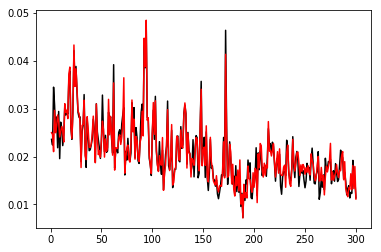

In [92]:
input_id = 8
#plt.plot(x, draw_x[input_id])
plt.plot(x, draw_target[input_id], color='black')
plt.plot(x, draw_y[input_id], color='red')

In [107]:
fig = plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

In [110]:
plt.rcParams['figure.figsize'] = [10, 10]

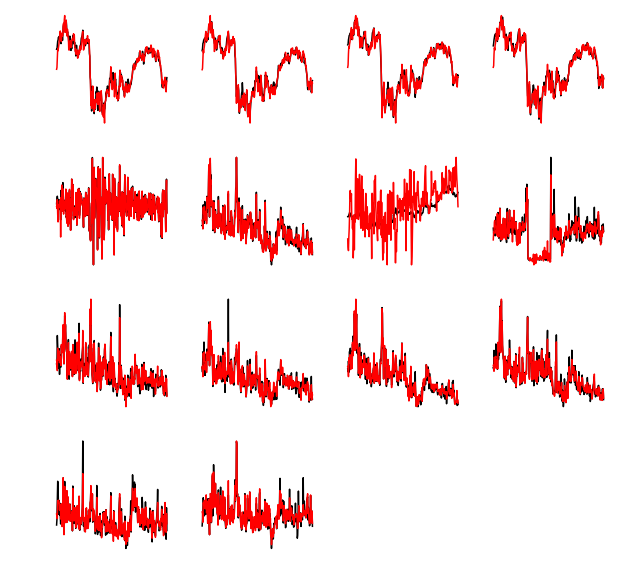

In [111]:
for i in range(n_inputs):
    plt.subplot(4,4,i+1)
    plt.plot(x, draw_target[i], color='black')
    plt.plot(x, draw_y[i], color='red')
    plt.axis('off')

### 드룹아웃이 적용된 multiRNN해보기

In [26]:
tf.reset_default_graph()

In [27]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
Y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [28]:
n_layers = 3
n_neurons = 200

keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [29]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [30]:
def shuffle_batch(X, Y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], Y[batch_idx]
        yield X_batch, y_batch

In [32]:
n_iterations = 1500
batch_size = 100
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        for X_batch, y_batch in shuffle_batch(X_data_train, Y_data_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, Y: y_batch})
        if iteration % 100 == 0:
            mse_train = loss.eval(feed_dict={X: X_data_train, Y: Y_data_train})
            mse_test = loss.eval(feed_dict={X: X_data_test, Y: Y_data_test})
            print(iteration, "\tMSE_train:", mse_train, "\tMSE_test:", mse_test)
            saver.save(sess, "./my_multiRNN_dropout_model") 

0 	MSE_train: 0.055407356 	MSE_test: 0.05540418
100 	MSE_train: 0.0009768927 	MSE_test: 0.0009788164
200 	MSE_train: 0.0032833228 	MSE_test: 0.0032765237
300 	MSE_train: 0.0021612276 	MSE_test: 0.0021592348
400 	MSE_train: 0.0030501154 	MSE_test: 0.0030474383
500 	MSE_train: 0.005143693 	MSE_test: 0.0051496313


KeyboardInterrupt: 

In [33]:
with tf.Session() as sess:                         
    saver.restore(sess, "./my_multiRNN_dropout_model")   
    X_new = X_data_test[180].reshape(-1, n_steps, n_inputs)
    Y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_multiRNN_dropout_model


In [34]:
draw_x = X_new.reshape(n_steps,n_inputs).T
draw_target = Y_data_test[180].T
draw_y = Y_pred.reshape(n_steps,n_inputs).T

In [35]:
x = np.arange(1,len(draw_x[0])+1)

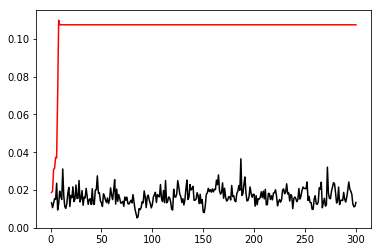

In [42]:
input_id = 12
#plt.plot(x, draw_x[input_id])
plt.plot(x, draw_target[input_id], color='black')
plt.plot(x, draw_y[input_id], color='red')

### LSTM으로 짜보기

In [112]:
tf.reset_default_graph()

In [113]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
Y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [114]:
n_layers = 1
n_neurons = 200

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.relu)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
#print (outputs)

In [115]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [116]:
def shuffle_batch(X, Y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], Y[batch_idx]
        yield X_batch, y_batch

In [54]:
n_iterations = 1500
batch_size = 100

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        for X_batch, y_batch in shuffle_batch(X_data_train, Y_data_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, Y: y_batch})
        if iteration % 100 == 0:
            #temp_outputs = outputs.eval(feed_dict={X: X_data_train, Y: Y_data_train})
            #print (len(temp_outputs[0][0][0]))
            mse_train = loss.eval(feed_dict={X: X_data_train, Y: Y_data_train})
            mse_test = loss.eval(feed_dict={X: X_data_test, Y: Y_data_test})
            print(iteration, "\tMSE_train:", mse_train, "\tMSE_test:", mse_test)
            saver.save(sess, "./my_multiRNN_LSTM_model") 

0 	MSE_train: 6.298028e-05 	MSE_test: 6.183872e-05
100 	MSE_train: 2.0815045e-05 	MSE_test: 2.036356e-05
200 	MSE_train: 2.0753761e-05 	MSE_test: 2.0311607e-05
300 	MSE_train: 2.0728437e-05 	MSE_test: 2.028428e-05
400 	MSE_train: 2.0630228e-05 	MSE_test: 2.0179827e-05
500 	MSE_train: 2.0565534e-05 	MSE_test: 2.0129426e-05
600 	MSE_train: 2.063326e-05 	MSE_test: 2.0204143e-05
700 	MSE_train: 2.0595593e-05 	MSE_test: 2.016647e-05
800 	MSE_train: 2.043865e-05 	MSE_test: 2.0024405e-05
900 	MSE_train: 2.0329502e-05 	MSE_test: 1.994617e-05
1000 	MSE_train: 2.0752464e-05 	MSE_test: 2.038694e-05
1100 	MSE_train: 1.9959718e-05 	MSE_test: 1.9619292e-05
1200 	MSE_train: 2.0001593e-05 	MSE_test: 1.9679728e-05
1300 	MSE_train: 2.0010766e-05 	MSE_test: 1.9703064e-05
1400 	MSE_train: 1.9706411e-05 	MSE_test: 1.940399e-05


In [117]:
with tf.Session() as sess:                         
    saver.restore(sess, "./my_multiRNN_LSTM_model")   
    X_new = X_data_test[0].reshape(-1, n_steps, n_inputs)
    Y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_multiRNN_LSTM_model


In [118]:
draw_x = X_new.reshape(n_steps,n_inputs).T
draw_target = Y_data_test[0].T
draw_y = Y_pred.reshape(n_steps,n_inputs).T

In [119]:
x = np.arange(1,len(draw_x[0])+1)

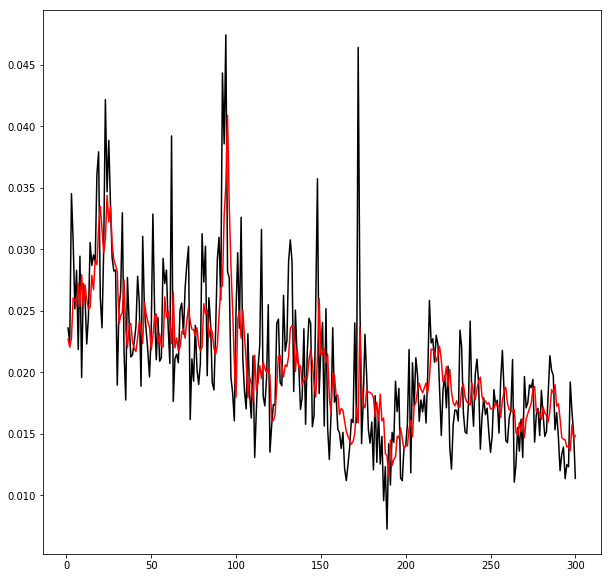

In [120]:
input_id = 8
#plt.plot(x, draw_x[input_id])
plt.plot(x, draw_target[input_id], color='black')
plt.plot(x, draw_y[input_id], color='red')

In [121]:
fig = plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

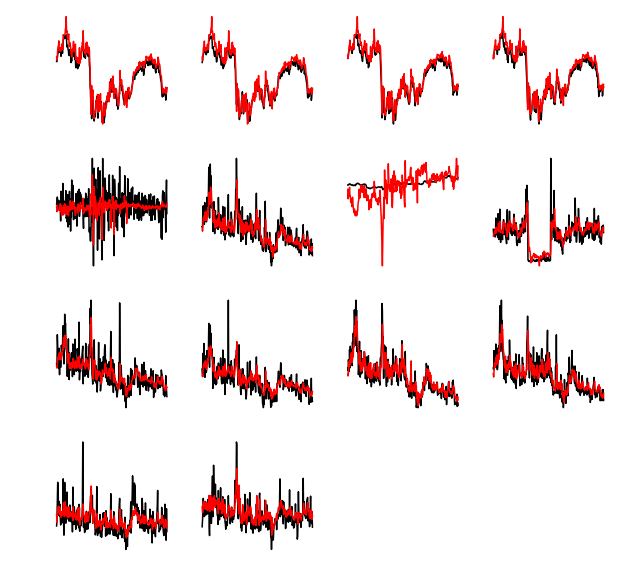

In [122]:
for i in range(n_inputs):
    plt.subplot(4,4,i+1)
    plt.plot(x, draw_target[i], color='black')
    plt.plot(x, draw_y[i], color='red')
    plt.axis('off')